**------------------------------------------------------------------------------------------------------------------------------------------------------**

**Input: Prediction(s) obtained from a trained GNN - GraphSAGE, GCN and GAT**

**Use Case: This notebook returns a small subgraph of the input graph that contains the most important nodes and edges that were most influential for the prediction(s) using Integrated Gradients and Saliency Maps**

**------------------------------------------------------------------------------------------------------------------------------------------------------**

# Librairies

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import networkx as nx
import json

import os
import re
import random
import itertools

import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

import dgl
import dgl.nn as dglnn
import dgl.function as fn
from dgl.nn import HeteroGraphConv, SAGEConv, GraphConv, GATConv
from dgl.data.utils import save_graphs, load_graphs

from torch_geometric.explain import characterization_score

from captum.attr import Saliency, IntegratedGradients

from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

from functools import partial

import warnings
warnings.simplefilter("ignore")

from src.utils import *
from src.gnn import *
from src.explain import *

In [2]:
# etype we want to predict
etype = ('Compound', 'DRUGBANK::treats::Compound:Disease', 'Disease')

# 1) Get Subgraph

**Get DRKG**

In [3]:
df = pd.read_csv('Input/DRKG/drkg.tsv', sep='\t', header=None)
df = df.dropna()

**Define subgraph for Alzheimer, we drop all the 'compound treats disease (not Alzheimer)' edges**

In [4]:
labels = df[(df[1] == "DRUGBANK::treats::Compound:Disease") & (df[2] != "Disease::MESH:D000544")].index
df = df.drop(labels=labels)

**Create HeteroGraph**

In [5]:
node_dict = get_node_dict(df)
edge_dict = get_edge_dict(df, node_dict)
g = dgl.heterograph(edge_dict)

**Add node features**

In [6]:
g, node_features = add_node_features(g)

**Construct negative graph**

In [7]:
g_neg = construct_negative_graph(g, etype)

# 2) Measure Explainability

In [8]:
def sample_heads(true_head, embed):
    '''Samples random heads to compute Hits@5, Hits@10'''
    num_neg_samples = 0
    max_num = 99
    candidates = []
    nodes = list(range(embed['Compound'].size()[0]))
    random.shuffle(nodes)

    while num_neg_samples < max_num:    
        sample_head = nodes[num_neg_samples]
        if sample_head != true_head:
            candidates.append(sample_head)
        num_neg_samples += 1
    
    candidates.append(true_head.item())
    candidates_embeds = torch.index_select(embed['Compound'], 0, torch.tensor(candidates))

    return candidates, candidates_embeds

In [9]:
def get_rank(true_head, true_tail, embed):
    '''Gets rank of true head'''
    x = torch.select(embed['Compound'], 0, true_tail)
    x = x.view(1, x.size()[0])

    candidates, candidates_embeds = sample_heads(true_head, embed)

    distances = torch.cdist(candidates_embeds, x, p=2)
    dist_dict = {cand: dist for cand, dist in zip(candidates, distances)} 

    sorted_dict = dict(sorted(dist_dict.items(), key=operator.itemgetter(1), reverse=True))
    sorted_keys = list(sorted_dict.keys())

    ranks_dict = {sorted_keys[i]: i for i in range(0, len(sorted_keys))}
    rank = ranks_dict[true_head.item()]
    return rank

In [10]:
def get_all_ranks(g, etype, mode):
    '''Gets all the ranks having as input either g, g_explain or g_complement'''
    ranks = []
    ranks_explain = []
    ranks_complement = []

    for i in range(len(g.edges(etype=etype, form='eid'))):
        
        print(mode + ': ' + str(i))
        
        g_single_instance, g_neg_single_instance, u, v = get_single_instance_graph(g, etype, i)
        imp_node_dic = get_imp_node_dic(etype, g_single_instance, g_neg_single_instance, mode)
        
        with open(f"Output/Explainability/Alzheimer/imp_node_dict_{i}_{mode}.json", "w") as file:
            json.dump(imp_node_dic, file)

        _, _, embed = model(g_single_instance, g_neg_single_instance, g_single_instance.ndata['h'], etype)
        rank = get_rank(u, v, embed)
        ranks.append(rank)

        _, _, embed_explain = get_explain_y_hat(g_single_instance, imp_node_dic, etype, u, v,)
        rank = get_rank(u, v, embed_explain)
        ranks_explain.append(rank)

        _, _, embed_complement = get_complement_y_hat(g_single_instance, imp_node_dic, etype, u, v,)
        rank = get_rank(u, v, embed_complement)
        ranks_complement.append(rank)
    
    return ranks, ranks_explain, ranks_complement

In [ ]:
###

In [12]:
i = 1
mode = 'ig'

In [13]:
g_single_instance, g_neg_single_instance, u, v = get_single_instance_graph(g, etype, i)
imp_node_dic = get_imp_node_dic(etype, g_single_instance, g_neg_single_instance, mode)

In [17]:
with open(f"Output/Explainability/Alzheimer/imp_node_dict_{i}_{mode}.json", "w") as file:
    json.dump(imp_node_dic, file)

In [14]:
 _, _, embed = model(g_single_instance, g_neg_single_instance, g_single_instance.ndata['h'], etype)
get_rank(u, v, embed)

7

In [18]:
_, _, embed_explain = get_explain_y_hat(g_single_instance, imp_node_dic, etype, u, v)
get_rank(u, v, embed_explain)

99

In [19]:
_, _, embed_complement = get_complement_y_hat(g_single_instance, imp_node_dic, etype, u, v)
get_rank(u, v, embed_complement)

16

In [ ]:
###

In [ ]:
ranks_ig, ranks_explain_ig, ranks_complement_ig = get_all_ranks(g, etype, 'ig')
ranks_sal, ranks_explain_sal, ranks_complement_sal = get_all_ranks(g, etype, 'sal')

# 3) Get Explanation

**Instance**

In [20]:
i = 1
mode = 'ig'

In [25]:
g_single_instance, g_neg_single_instance, u, v = get_single_instance_graph(g, etype, i)

In [23]:
with open(f"Output/Explainability/Alzheimer/imp_node_dict_{i}_{mode}.json") as file:
    imp_node_dict = json.load(file)

In [27]:
compound_name = list(node_dict[etype[0]].keys())[u]
disease_name = list(node_dict[etype[2]].keys())[v]

In [28]:
print(f'Compound Name: {compound_name}')
print(f'Disease Name: {disease_name}')

Compound Name: Compound::DB00674
Disease Name: Disease::MESH:D000544


**Explanatory subgraph**

In [29]:
g_explain = g_single_instance

for ntype in g_single_instance.ntypes:
    if ntype in list(imp_node_dic.keys()):
        # keep influential nodes
        nids = list(set(g_single_instance.nodes(ntype).detach().numpy()) - set(imp_node_dic[ntype]))
        g_explain = dgl.remove_nodes(g_explain, nids=nids, ntype=ntype)
    else:
        nids = list(set(g_single_instance.nodes(ntype).detach().numpy()))
        g_explain = dgl.remove_nodes(g_explain, nids=nids, ntype=ntype)

g_explain = dgl.add_edges(g_explain, u, v, etype=etype)

**Label important nodes**

In [32]:
imp_nodes = []
imp_nodes.append(compound_name)
imp_nodes.append(disease_name)
for key in imp_node_dict.keys():
    #print(key + ':')
    lst = imp_node_dict[key]
    for x in lst:
        #print(list(node_dict[key].keys())[x])
        imp_nodes.append(list(node_dict[key].keys())[x])
    #print()

**Add Interaction-type**

In [34]:
df_explain = df[(df[0].isin(imp_nodes)) & (df[2].isin(imp_nodes))]
df_explain = df_explain.append(df[(df[0] == compound_name) & 
                                  (df[1] == "DRUGBANK::treats::Compound:Disease") & 
                                  (df[2] == disease_name)])
df_glossary = pd.read_csv('Input/DRKG/relation_glossary.tsv', sep='\t')
df_explain = df_explain.merge(df_glossary[['Relation-name', 'Interaction-type']], right_on='Relation-name', left_on=df_explain[1])

In [58]:
#df_explain['Interaction-type'].value_counts()[:10]

**Plot**

In [59]:
G = nx.from_pandas_edgelist(df_explain, 0, 2, edge_attr=True, create_using=nx.MultiDiGraph())

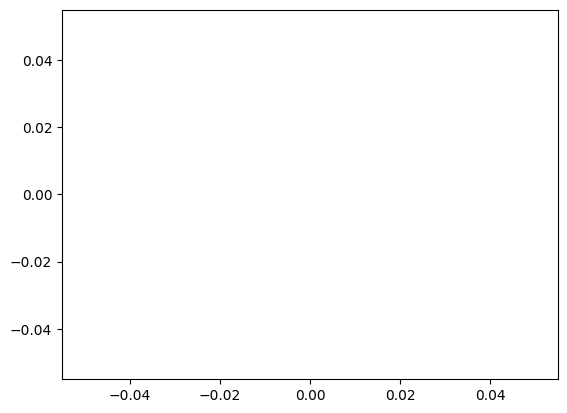

In [60]:
import matplotlib.patches as mpatches
color = ['orangered', 'lightgreen', 'darkorange', 'lightcyan', 'darkviolet']
label = ['Target Link', 'Anatomy', 'Compound', 'Gene', 'Pharmacologic Class']
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=color[i], label="{:s}".format(label[i]))[0] for i in range(len(label))]

In [61]:
labels = {}
for node in G.nodes:
    split = node.split('::')
    labels[node] = split[len(split)-1]

In [62]:
node_color = []
for node in G:
    if node == compound_name or node == disease_name:
        node_color.append('orangered')
    else:
        if node.startswith('Anatomy'):
            node_color.append('lightgreen')
        elif node.startswith('Compound'):
            node_color.append('darkorange')
        elif node.startswith('Disease'):
            node_color.append('skyblue')
        elif node.startswith('Gene'):
            node_color.append('lightcyan')
        elif node.startswith('Pharmacologic'):
            node_color.append('darkviolet')

In [63]:
edge_labels = {}
edge_label_target = {}
for i, row in df_explain.iterrows():
    split = row[1].split('::')
    pair = (row[0], row[2])
    
    if row[0] == compound_name and row[2] == disease_name:
        edge_label_target[pair] = row['Interaction-type']
    else:
        edge_labels[pair] = row['Interaction-type']

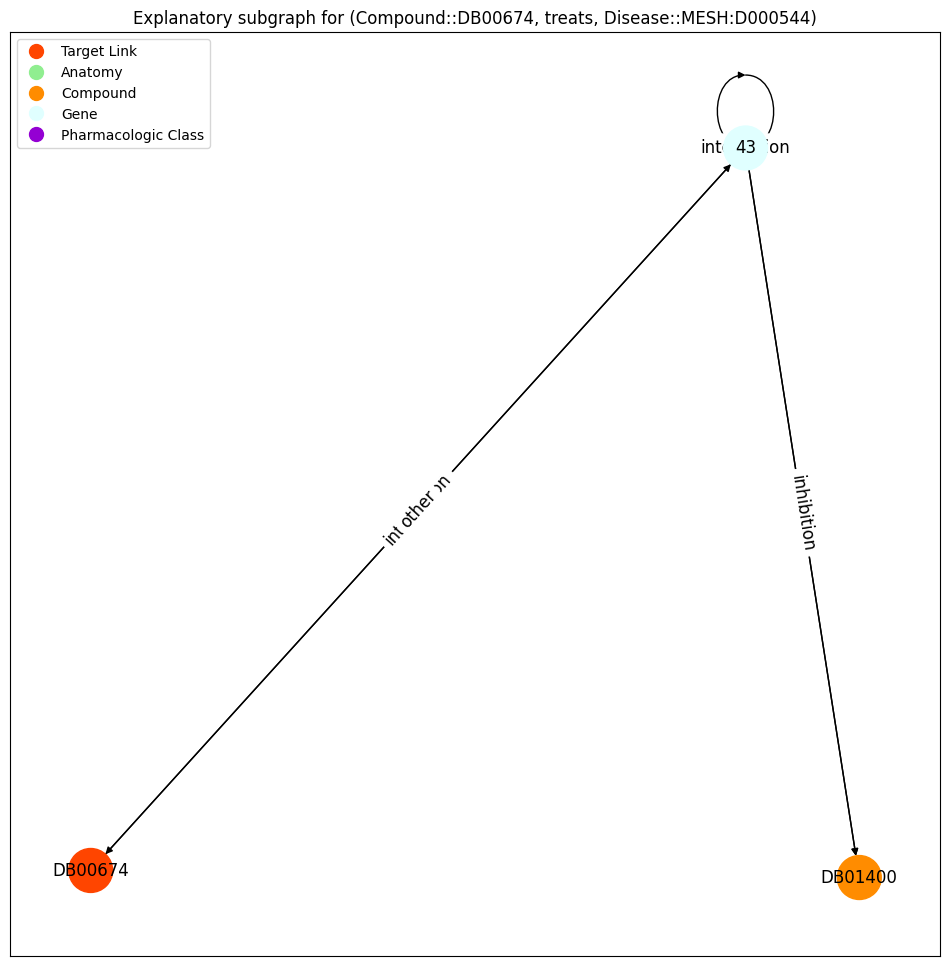

In [67]:
plt.figure(figsize = (12, 12))
pos = nx.spring_layout(G, k = 2.5)
nx.draw_networkx(G, with_labels=True, node_color=node_color, node_size=1000, pos=pos, font_weight='bold', font_size=12, labels=labels)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_label_target, font_color='orangered', font_size=12)
plt.legend(handles=patches)
plt.title(f'Explanatory subgraph for ({compound_name}, treats, {disease_name})')
plt.show()